<h1 style = font-size: 100px>Notebook for "Knowledge Graph Link Prediction based on Text" by Haitz Sáez de Ocáriz Borde, 2022 </h1>

We use the same dataset used in GraphWriter
https://github.com/rikdz/GraphWriter

The following files are required:

1. preprocessed.train.tsv
2. preprocessed.test.tsv

To load pretrained models (otherwise train from scratch):

3. d2v.model
4. predictor

<h1> Clone Data from my Github

In [ ]:
!git clone https://github.com/haitzsaezdeocariz/kg_data.git

Cloning into 'kg_data'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [ ]:
!unzip kg_data/preprocessed_data.zip

Archive:  kg_data/preprocessed_data.zip
  inflating: preprocessed.test.tsv   
  inflating: preprocessed.train.tsv  
  inflating: preprocessed.val.tsv    


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/TRAINING_SET_ALL.zip' TRAINING_SET_ALL.zip

Mounted at /content/gdrive


In [ ]:
!unzip TRAINING_SET_ALL.zip

Archive:  TRAINING_SET_ALL.zip
  inflating: TRAINING_SET_ALL        


<h1> Installs

Note: for some reason we need to downgrade pytorch, otherwise colab will collapse (May 2022)

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html

     |████████████████████████████████| 7.9 MB 8.8 MB/s 


In [ ]:
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 3.5 MB 5.9 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 962 kB/s eta 0:22:35tcmalloc: large alloc 1147494400 bytes == 0x39992000 @  0x7fbe44470615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.2 MB/s eta 0:14:44tcmalloc: large alloc 1434370048 bytes == 0x7dfe8000 @  0x7fbe44470615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████            | 1336.2 MB 1.2

<h1> Dataset: Description and Importing

AGENDA DATASET
1. Text Graph Pairings
2. 40k SAMPLES approx
3. Graphs are small

Clarification about the data (given by GraphWriter author in Github thread)

You can process your data to a tab-separated list with the following fields:

title, entities, entity type, graph, target, ordering

1. "title" paper title
2. "entities" is a semi-colon delimited list of entities
3. "entity type" is a space delimited list of one type token associated with each entity
4. "graph" is a semi-colon delimited list of graph triples, where the head and tail are indexes of the entities in the "entities" list and the relation is the index of the relation in the data/relations.vocab file. <head, relation, tail> triples divided by ';'
5. "target" is your target text with entities replaced by placeholders indicating the entity type and its index in the "entities" list
6. "ordering" is not used, but you may need to put a placeholder there to get the code to work as is. Alternately, you can modify the code to ignore this field

In [1]:
import csv
tsv_file = open("preprocessed.train.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

title, entities, entity_type, graph, target, ordering = [],[],[],[],[],[]
for row in read_tsv:
  title.append(row[0])
  entities.append(row[1])
  entity_type.append(row[2])
  graph.append(row[3])
  target.append(row[4])
  ordering.append(row[5])

<h1> View data <h1>

In this cells we visualize the different columns of the tsv file for a given sample

In [2]:
title[0]

'Constrained minimization technique for topic identification using discriminative training and support vector machines .'

In [3]:
entities[0]

'latent semantic indexing matrix ; discrimina-tive training ; constrained minimization approach ; support vector machines ; banking call routing ; combination strategy ; classification error ; classification accuracy ; classifier accuracy ; switchboard databases ; vector-space model ; lsi matrix ; baseline classifiers ; score separation ; classifiers ; ensemble ; classifier ; accuracy'

In [4]:
entity_type[0]

'<method> <method> <method> <method> <task> <method> <task> <metric> <metric> <material> <method> <method> <method> <metric> <method> <method> <method> <metric>'

In [5]:
graph[0]

'17 5 16 ; 1 0 11 ; 2 0 11 ; 2 0 7 ; 1 0 6 ; 16 4 12 ; 17 5 12 ; 3 1 0 ; 14 1 2'

In [6]:
target[0]

'this paper describes the <method_2> to combine multiple <method_14> in order to improve <metric_7> . since errors of individual <method_14> in the <method_15> should somehow be uncorrelated to yield higher <metric_7> , we propose a <method_5> where the combined <metric_8> is a function of the correlation between classification errors of the individual <method_14> . to obtain powerful single <method_14> , different techniques are investigated including <method_3> and <method_0> , which is a popular <method_10> . we also investigate <method_1> of the <method_11> on <method_2> . <method_1> minimizes the <task_6> by increasing the <metric_13> of the correct from competing documents . experimental evaluation is carried out on a <task_4> and on <material_9> with a set of 23 and 67 topics respectively . results show that the combined <method_16> we propose outperforms the <metric_17> of individual <method_12> by 44 % .'

In [7]:
ordering[0]

'2 14 7 22 27 18 -1 15 5 8 18 -1 3 0 10 26 18 -1 1 11 20 21 18 -1 6 13 23 18 -1 18 -1 4 9 19 24 25 18 -1'

<h1> Recover abstract from target (We predict the KG based on the abstract and the node entities)

Recover the abstract based on the different columns in the tsv file

In [8]:
import re

In [9]:
abstract=[]
for row in range(38720):
  split_text = re.split('<|>',target[row])
  abstract_temporal=''
  for i in split_text:
    if i[0:6] == 'method':
      try:
        index=int(i[7:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:6] == 'metric':
      try:
        index=int(i[7:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:4] == 'task':
      try:
        index=int(i[5:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:len('otherscientificterm')] == 'otherscientificterm':
      try:
        index=int(i[len('otherscientificterm')+1:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:len('material')] == 'material':
      try:
        index=int(i[len('material')+1:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    else:
      abstract_temporal += i
  abstract.append(abstract_temporal)

In [10]:
abstract[0]

'this paper describes the  constrained minimization approach  to combine multiple  classifiers  in order to improve  classification accuracy  . since errors of individual  classifiers  in the  ensemble  should somehow be uncorrelated to yield higher  classification accuracy  , we propose a  combination strategy  where the combined  classifier accuracy  is a function of the correlation between classification errors of the individual  classifiers  . to obtain powerful single  classifiers  , different techniques are investigated including  support vector machines  and latent semantic indexing matrix  , which is a popular  vector-space model  . we also investigate  discrimina-tive training  of the  lsi matrix  on  constrained minimization approach  .  discrimina-tive training  minimizes the  classification error  by increasing the  score separation  of the correct from competing documents . experimental evaluation is carried out on a  banking call routing  and on  switchboard databases  wi

<h1> Vectorize Text

We need to find a way to vectorize the text:
1. The node entities (which may contain multiple words)
2. The abstracts

<h1> Tokenizing with Transformers

In [11]:
# !pip install -U sentence-transformers

Link to pretrained models

https://www.sbert.net/docs/pretrained_models.html

In [12]:
# from sentence_transformers import SentenceTransformer

# # We are using "paraphrase-MiniLM-L6-v2" model here, You can find list of model [here][2]
# # all-mpnet-base-v2
# # allenai-specter
# model = SentenceTransformer('allenai-specter')

In [13]:
embedding=768

<h1> Create Graph Class with all necessary data

Here we create a few helper functions and a Graph class which contains all the information we will later need for training our Knowledge Graph link predictor.

In [14]:
import numpy as np
import torch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.doc2vec import Doc2Vec
from scipy.sparse import csr_matrix

def A_to_onehot(A):
  A_onehot = np.zeros((A.shape[0],A.shape[1],8))
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      A_onehot[i,j,int(A[i,j])]=1
  return A_onehot

def get_fully_connected(nodes):
  edge_index,_=from_scipy_sparse_matrix(csr_matrix(np.ones((len(nodes),len(nodes)))))
  return torch.Tensor(edge_index.float()).type(torch.int64).cuda()

def from_scipy_sparse_matrix(A):
    r"""Converts a scipy sparse matrix to edge indices and edge attributes.

    Args:
        A (scipy.sparse): A sparse matrix.
    """
    A = A.tocoo()
    row = torch.from_numpy(A.row).to(torch.long)
    col = torch.from_numpy(A.col).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_weight = torch.from_numpy(A.data)
    return edge_index, edge_weight

def vectorize_nodes(nodes,attach_abstract,vectorized_abstract):
        for i in range(len(nodes)):
          if attach_abstract:
            if i ==0:
              node_vector=model.encode([nodes[i].lower()])
              node_vector= np.concatenate((node_vector,vectorized_abstract),axis=1)
            else:
              node_vector=np.concatenate(
                  (node_vector,
                  
                  np.concatenate((
                  model.encode([nodes[i].lower()]),vectorized_abstract),axis=1)

                  ),axis=0
              )
          else:
            if i ==0:
              node_vector=model.encode([nodes[i].lower()])
            else:
              node_vector=np.concatenate(
                  (node_vector,
                  model.encode([nodes[i].lower()])
                  ),axis=0
              )  
        return node_vector


def flatten_onehot(A_one_hot):
  flattened_vector = A_one_hot[0,0,:][None,:]
  first_pass = True
  for i in range(A_one_hot.shape[0]):
    for j in range(A_one_hot.shape[1]):
      if first_pass==False:
        flattened_vector=torch.cat((flattened_vector,A_one_hot[i,j,:][None,:]),axis=0)
      first_pass = False
  return flattened_vector

class Graph(object):
    def __init__(self,
                 nodes,
                 node_type,
                 A,
                 A_attr,
                 edge_attr,
                 abstract,
                 target,
                 title,
                 attach_abstract=False
                 ):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        #Nodes -> List of strings containing each entity
        self.nodes = nodes
        #Node type -> List of strings based on entity type
        # self.node_type = node_type
        #Adjacency matrix -> numpy matrix
        self.A = csr_matrix(A)
        #Adjacency matrix with attributes -> numpy matrix
        self.A_attr = A_attr
        self.A_onehot = flatten_onehot(torch.Tensor(A_to_onehot(A_attr)).cuda())
        self.A_onehot_no_flatten=torch.Tensor(A_to_onehot(A_attr)).cuda()
        # self.edge_index, self.edge_weight = from_scipy_sparse_matrix(csr_matrix(A_attr))
        #Edge attribute -> list of lists with edge type (relation) and i,j indeces
        # self.edge_attr = edge_attr
        #Abstract corresponding to the graph -> string
        # self.abstract = abstract
        #Original abstract without substituting node entities -> string
        # self.target = target
        #Title -> Paper title (useless) -> string
        # self.title = title

        #Vectorized graph information
        self.vectorized_abstract=model.encode([abstract.lower()])
        self.relations = ["USED-FOR","CONJUNCTION","FEATURE-OF","PART-OF","COMPARE","EVALUATE-FOR","HYPONYM-OF"]
        #Whether to attach abstract vectorization to node features
        self.attach_abstract = attach_abstract

        #Node features x
        self.x = torch.Tensor(vectorize_nodes(self.nodes,self.attach_abstract,self.vectorized_abstract)).cuda()
        #Fully connected A matrix for GAT
        self.fully_connected = get_fully_connected(self.nodes)
        #Retrive number of nodes in the graph
        self.num_nodes = int(self.x.shape[0]) 

    def set_batch(self, batch): #useful for batching
        self.batch = batch   

    def get_triples(self):
        for index in range(len(self.edge_attr)):
          
          print(self.nodes[self.edge_attr[index][1]]+' -> '+self.relations[self.edge_attr[index][0]]+' -> '+self.nodes[self.edge_attr[index][2]])

In [15]:
train_examples = 19500
test_examples = 500
attach_abstract=False

We store all the training data in a list of Graphs. One Graph for each data point.

Uncomment to preprocess data (I am loading it from my google drive instead)

In [16]:

# from inspect import Traceback
# TRAINING_SET_ALL = []

# from tqdm import tqdm



# for row in tqdm(range(38720)): #training data has 38720 samples
#   matrix_size = len(re.split(';',entities[row]))
#   A = np.zeros((matrix_size,matrix_size))
#   A_attr = np.zeros((matrix_size,matrix_size))
#   graph_row=re.split(';',graph[row])
#   edge_attr = []
#   for entries in range(len(graph_row)):
#     i = graph_row[entries].split()[0]
#     j = graph_row[entries].split()[-1]
#     A_attr[int(i),int(j)]=int(graph_row[entries].split()[1])+1
#     A[int(i),int(j)]=1
#     # First entry is the attribute, other are i and j (edge indexes)
#     edge_attr.append([int(graph_row[entries].split()[1]),int(graph_row[entries].split()[0]),int(graph_row[entries].split()[-1])])

#   TRAINING_SET_ALL.append(Graph(
#       nodes = re.split(';',entities[row]),
#       node_type = entity_type[row],
#       A=A,
#       A_attr = A_attr,
#       edge_attr = edge_attr,
#       abstract = abstract[row],
#       target = target[row],
#       title = title[row],
#       attach_abstract=attach_abstract
#   ))

In [17]:
import pickle
# with open("TRAINING_SET_ALL", "wb") as fp:   #Pickling
#   pickle.dump(TRAINING_SET_ALL, fp)
with open("TRAINING_SET_ALL", "rb") as fp:   # Unpickling
  TRAINING_SET_ALL= pickle.load(fp)

In [18]:
TRAINING_SET = TRAINING_SET_ALL[0:train_examples]

Uncommented to calculate weighting, I'm loading them from github

In [19]:
import numpy as np
class_weights = np.load('kg_data/class_weights_20k.npy')
# from sklearn.utils.class_weight import compute_class_weight
# y_cw = []
# for row in range(len(TRAINING_SET)):
#   for i in range(TRAINING_SET[row].A_onehot.shape[0]):
#     y_cw.append(np.argmax(np.array(TRAINING_SET[row].A_onehot[i,:].cpu().detach())))
# y_cw = np.array(y_cw)
# class_weights = compute_class_weight(
#     class_weight = "balanced",
#     classes = np.arange(8),
#     y =y_cw)
# del y_cw
# print(class_weights)

<h1> Code GNN

In [20]:
#Imports (note that some are unnecessary)
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GraphNorm
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
import torch.nn as nn
pdist = nn.PairwiseDistance(p=2)
from torch.nn import Linear, ELU, BatchNorm1d, Module, Sequential, Softmax
from torch_scatter import scatter
from torch_scatter import scatter_mean

Code last layer for link prediction. We use as template MessagePassing. We take the node features from each node and pass them through a MLP (psi(h_i,h_j)) with output layer with 8 nodes (one for each possible link class) and a softmax activation. Node that the graph is fully-connected, so we calculate link_ij for every node combination possible.

In [21]:
class link_prediction_layer(MessagePassing):
    # Note that we take as template MessagePassing.
    # In practice, we do not really use aggregate and update, we simply pass the data through the functions
    def __init__(self,graph_embeddings=20):
        super().__init__()


        # MLP `\psi` for computing messages `link_ij`
        # dims: 2d -> 8 (combining feature from 2 nodes, obtain PMF over the 8 link classes) 
        self.mlp_link = Sequential(
            Linear(graph_embeddings*2,graph_embeddings), BatchNorm1d(graph_embeddings), ELU(),
            Linear(graph_embeddings,graph_embeddings), BatchNorm1d(graph_embeddings), ELU(),
            Linear(graph_embeddings,graph_embeddings), BatchNorm1d(graph_embeddings), ELU(),
            Linear(graph_embeddings, 8), Softmax(),
          )

    def forward(self, h, edge_index):
        """
        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)

        Returns:
            link_ij: (n**2, 8), fully-connected graph so n**2
        """
        out = self.propagate(edge_index=edge_index, h=h)
        return out

    def message(self, h_i, h_j):
        """
        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
        Returns:
            link_ij: (n**2, 8) - messages `msg_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j], dim=-1)
        return self.mlp_link(msg)
    
    def aggregate(self, inputs):
        return inputs
    
    def update(self,inputs):
        return inputs

In [22]:
class link_prediction_layer_with_transformer(MessagePassing):
    # Note that we take as template MessagePassing.
    # In practice, we do not really use aggregate and update, we simply pass the data through the functions
    def __init__(self,graph_embeddings=20):
        super().__init__()

        self.graph_embeddings=graph_embeddings
        # MLP `\psi` for computing messages `link_ij`
        # dims: 2d -> 8 (combining feature from 2 nodes, obtain PMF over the 8 link classes) 
        self.mlp_link = Sequential(
            Linear(self.graph_embeddings,int(self.graph_embeddings/2)), BatchNorm1d(int(self.graph_embeddings/2)), ELU(),
            Linear(int(self.graph_embeddings/2), 8), Softmax(),
          )
        self.transformer = torch.nn.Transformer(self.graph_embeddings,nhead=4, num_encoder_layers=16)

    def forward(self, h, edge_index):
        """
        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)

        Returns:
            link_ij: (n**2, 8), fully-connected graph so n**2
        """
        out = self.propagate(edge_index=edge_index, h=h)
        return out

    def message(self, h_i, h_j):
        """
        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
        Returns:
            link_ij: (n**2, 8) - messages `msg_ij` passed through MLP `\psi`
        """
        msg = self.transformer(h_i[:,None,:],h_j[:,None,:])[:,0,:]
        return self.mlp_link(msg)
    
    def aggregate(self, inputs):
        return inputs
    
    def update(self,inputs):
        return inputs

Code GNN

1. GAT layers + ELU + graphnorm x3
2. link_prediction_layer

In [23]:
class LINK_PREDICTOR(torch.nn.Module):
    def __init__(self,heads=1):
        super(LINK_PREDICTOR, self).__init__()
        if attach_abstract:
          self.hidden_channels = embedding*2
        else:
          self.hidden_channels = embedding

        self.graph_embeddings = 20
        self.heads = heads
        self.attention_channels = self.hidden_channels

        # self.MLP_features1 = Sequential(Linear(self.hidden_channels,self.attention_channels), 
        #                                ELU(),
        #                                BatchNorm1d(self.attention_channels), 
        #                                )

        #self.transformer = torch.nn.Transformer(self.hidden_channels,nhead=4, num_encoder_layers=4)

  
        
        # self.MLP_features2 = Sequential(Linear(self.attention_channels,self.graph_embeddings), 
        #                                ELU(),
        #                                BatchNorm1d(self.graph_embeddings), 
        #                                )
        # self.l1 = GATConv(self.attention_channels,self.attention_channels,heads=self.heads)
        # self.l1_heads = Linear(self.graph_embeddings*self.heads,self.graph_embeddings)
        # self.l2 = GATConv(self.graph_embeddings,self.graph_embeddings,heads=self.heads)
        # self.l2_heads = Linear(self.graph_embeddings*self.heads,self.graph_embeddings)
        # self.l3 = GATConv(self.graph_embeddings,self.graph_embeddings,heads=self.heads)
        # self.l3_heads = Linear(self.graph_embeddings*self.heads,self.graph_embeddings)
        self.link_prediction_layer = link_prediction_layer(graph_embeddings=self.attention_channels)
        # self.norm = GraphNorm(self.hidden_channels)
        self.ELU = ELU()
    def forward(self,x,edge_index):
        #Transform features to latent space, extract relationships entity vs abstract
        # x = self.MLP_features1(x)
        #x = self.transformer(x[:,None,:],x[:,None,:])
        #x = x[:,0,:]
        # x = self.MLP_features2(x[:,0,:])
        # #Fully-connected graph with GATs
        # x = self.ELU(self.l1(x,edge_index))
        # x = self.ELU(self.l1_heads(x))
        #x = self.norm(x)
        # x = self.ELU(self.l2(x,edge_index))
        # x = self.ELU(self.l2_heads(x))
        # x = self.norm(x)
        # x = self.ELU(self.l3(x,edge_index))
        # x = self.ELU(self.l3_heads(x))
        # x = self.norm(x)
        #Link prediction layer     
        x = self.link_prediction_layer(x,edge_index)
        return x

In [24]:
class LINK_PREDICTOR_with_transformer(torch.nn.Module):
    def __init__(self,heads=1):
        super(LINK_PREDICTOR_with_transformer, self).__init__()
        if attach_abstract:
          self.hidden_channels = embedding*2
        else:
          self.hidden_channels = embedding

        self.graph_embeddings = 20
        self.heads = heads
        self.attention_channels = 20

        self.MLP_features1 = Sequential(Linear(self.hidden_channels,self.attention_channels), 
                                       ELU(),
                                       BatchNorm1d(self.attention_channels), 
                                       )

        #self.transformer = torch.nn.Transformer(self.hidden_channels,nhead=4, num_encoder_layers=4)

  
        
        # self.MLP_features2 = Sequential(Linear(self.attention_channels,self.graph_embeddings), 
        #                                ELU(),
        #                                BatchNorm1d(self.graph_embeddings), 
        #                                )
        #self.l1 = GATConv(self.hidden_channels,self.hidden_channels,heads=self.heads)
        # self.l1_heads = Linear(self.graph_embeddings*self.heads,self.graph_embeddings)
        # self.l2 = GATConv(self.graph_embeddings,self.graph_embeddings,heads=self.heads)
        # self.l2_heads = Linear(self.graph_embeddings*self.heads,self.graph_embeddings)
        # self.l3 = GATConv(self.graph_embeddings,self.graph_embeddings,heads=self.heads)
        # self.l3_heads = Linear(self.graph_embeddings*self.heads,self.graph_embeddings)
        self.link_prediction_layer_with_transformer = link_prediction_layer_with_transformer(graph_embeddings=self.attention_channels)
        # self.norm = GraphNorm(self.hidden_channels)
        self.ELU = ELU()
    def forward(self,x,edge_index):
        #Transform features to latent space, extract relationships entity vs abstract
        x = self.MLP_features1(x)
        #x = self.transformer(x[:,None,:],x[:,None,:])
        #x = x[:,0,:]
        # x = self.MLP_features2(x[:,0,:])
        # #Fully-connected graph with GATs
        #x = self.ELU(self.l1(x,edge_index))
        # x = self.ELU(self.l1_heads(x))
        #x = self.norm(x)
        # x = self.ELU(self.l2(x,edge_index))
        # x = self.ELU(self.l2_heads(x))
        # x = self.norm(x)
        # x = self.ELU(self.l3(x,edge_index))
        # x = self.ELU(self.l3_heads(x))
        # x = self.norm(x)
        #Link prediction layer     
        x = self.link_prediction_layer_with_transformer(x,edge_index)
        return x

<h1> Evaluation functions

1. accuracy_all: calculates the accuracy for all classes, rounds the prediction and compares to target one-hot vector. (for a single data point)
2. accuracy_all_max: calculates the accuracy for all classes, takes argmax of the prediction and compares to target one-hot vector. (for a single data point)
3. accuracy_important: same as accuracy_all but only considers classes which are not k_0
4. accuracy_important_max: same as accuracy_all_max but only considers classes which are not k_0
5. total_accuracy_all: computes the average accuracy of the test set using accuracy_all or accuracy_all_max. Accuracy_all_max is preferred.
6. total_accuracy_important: computes the average accuracy of the test set using accuracy_important or accuracy_important_max. Accuracy_important_max is preferred.

In [25]:
def accuracy_all(prediction,target):
  prediction=torch.round(prediction)
  correct=0
  wrong=0
  count = -1
  for i in range(target.shape[0]):
    count += 1
    for j in range(target.shape[1]):
      if j!=0:
        count +=1
      if sum(target[i,j,:]==prediction[count,:])==8:
        correct+=1
      else:
        wrong+=1

  return (correct/(correct+wrong))*100

def accuracy_all_max(prediction,target):
  correct=0
  wrong=0
  count = -1
  for i in range(target.shape[0]):
    count += 1
    for j in range(target.shape[1]):
      if j!=0:
        count +=1

      compare = np.zeros(prediction[count,:].shape)
      idx = int(prediction[count,:].argmax(axis=-1))
      compare[idx]=1
      compare=torch.Tensor(compare).cuda()
      if sum(target[i,j,:]==compare)==8:
        correct+=1
      else:
        wrong+=1

  return (correct/(correct+wrong))*100

def accuracy_important(prediction,target):
  prediction=torch.round(prediction)
  correct=0
  wrong=0
  count = -1
  for i in range(target.shape[0]):
    count += 1
    for j in range(target.shape[1]):
      if j!=0:
        count +=1
      if int(target[i,j,0])!=1:
        if sum(target[i,j,:]==prediction[count,:])==8:
          correct+=1
        else:
          wrong+=1
  return (correct/(correct+wrong))*100

def accuracy_important_max(prediction,target):
  correct=0
  wrong=0
  count = -1
  for i in range(target.shape[0]):
    count += 1
    for j in range(target.shape[1]):
      if j!=0:
        count +=1
      if int(target[i,j,0])!=1:
        compare = np.zeros(prediction[count,:].shape)
        idx = int(prediction[count,:].argmax(axis=-1))
        compare[idx]=1
        compare=torch.Tensor(compare).cuda()
        if sum(target[i,j,:]==compare)==8:
          correct+=1
        else:
          wrong+=1
  return (correct/(correct+wrong))*100

def total_accuracy_all(examples=100):
  start_count=38600
  total_performance=0
  for row in range(examples):
    
    prediction=predictor(
      TRAINING_SET_ALL[start_count+row].x, #x features
      TRAINING_SET_ALL[start_count+row].fully_connected #edge_index (note that graph-wise everything is fully-connected, but when we create a big batch from the different graph in the minibatch this is not the case anymore)
      )
    target = TRAINING_SET_ALL[start_count+row].A_onehot_no_flatten
    total_performance+=accuracy_all_max(prediction,target)
  return total_performance/examples

def total_accuracy_important(examples=100):
  start_count=38600
  total_performance=0
  for row in range(examples):
    prediction=predictor(
      TRAINING_SET_ALL[start_count+row].x, #x features
      TRAINING_SET_ALL[start_count+row].fully_connected #edge_index (note that graph-wise everything is fully-connected, but when we create a big batch from the different graph in the minibatch this is not the case anymore)
      )

    target = TRAINING_SET_ALL[start_count+row].A_onehot_no_flatten
    total_performance+=accuracy_important_max(prediction,target)
  return total_performance/examples

Graph_batch data class for batch training

In [26]:
class Graph_batch(object):
    def __init__(self,
                 edge_index,
                 x,
                 y
                 ):
      self.edge_index = edge_index
      self.x = x
      self.y = y

    def set_batch(self, batch): #useful for batching
      self.batch = batch 

Mini-batch function to parallelize computation

In [27]:
def create_mini_batch(graph_list):
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].fully_connected #Note that we are working with a fully-connected graph
    batch_x = graph_list[0].x #Node features
    batch_y = graph_list[0].A_onehot

    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)
    num_nodes_added= graph_list[0].num_nodes

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):
        # concat the features
        batch_x = torch.cat((batch_x,graph.x))
        # concat the labels
        batch_y = torch.cat((batch_y,graph.A_onehot))

        # concat the adjacency matrix as a block diagonal matrix
        batch_edge_index = torch.cat((batch_edge_index, torch.add(graph.fully_connected, num_nodes_added)), dim=1)
        num_nodes_added += graph.num_nodes
        batch_batch = torch.cat((batch_batch, torch.full((graph.num_nodes,), idx + 1)))
 
    batch_graph = Graph_batch(batch_edge_index, batch_x, batch_y)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

We will also use the F-measure to evaluate the model

1. Precision = TruePositives / (TruePositives + FalsePositives)
2. Recall = TruePositives / (TruePositives + FalseNegatives)
3. F-Measure = (2 * Precision * Recall) / (Precision + Recall)


In [28]:
from sklearn.metrics import precision_recall_fscore_support as score
import pandas
def prediction_2_onehot(a):
  return (a == a.max(axis=1)[:,None]).astype(int)

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

In [29]:
def print_fscore(start=train_examples,end=train_examples+test_examples):
  mini_batch_test = create_mini_batch(TRAINING_SET_ALL[start:end])
  precision, recall, fscore, support = score(
    prediction_2_onehot(
    predictor(
        mini_batch_test.x,
        mini_batch_test.edge_index
    ).cpu().detach().numpy())
    ,
    mini_batch_test.y.cpu().detach().numpy()
    )
  
  data = {'RELATION TYPE': ['NO LINK',"USED-FOR","CONJUNCTION","FEATURE-OF","PART-OF","COMPARE","EVALUATE-FOR","HYPONYM-OF"], 'F-SCORE': fscore}
  df = pandas.DataFrame(data=data)
  print(df)
  print('AVERGA FSCORE: ',np.mean(fscore))

Code to predict fscore of guessing majority class all the time

In [30]:
# mini_batch_test = create_mini_batch(TRAINING_SET)
# randomm=np.zeros((3368100, 8))
# randomm[:,0]=1
# precision, recall, fscore, support = score(
#     randomm,
#     mini_batch_test.y.cpu().detach().numpy()
# )
# data = {'RELATION TYPE': ['NO LINK',"USED-FOR","CONJUNCTION","FEATURE-OF","PART-OF","COMPARE","EVALUATE-FOR","HYPONYM-OF"], 'F-SCORE': fscore}
# df = pandas.DataFrame(data=data)
# print(df)
# print('AVERGA FSCORE: ',np.mean(fscore))

(Performance on 20k samples from training_set)

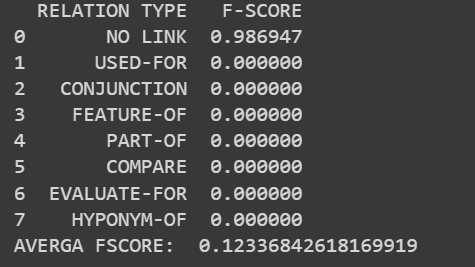

Link to blog on how to deal with imbalanced classification data

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/

<h1> Training

Code Cross Entropy function for Link prediction

In [31]:
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(class_weights),reduction='mean').cuda()

Training loop

In [32]:
import random
#Initialize predictor
predictor = LINK_PREDICTOR().cuda()
#Load pre-trained model
# predictor = torch.load('predictor')
#Use cuda (note that all other tensors have already been moved to cuda in previous cells)
predictor.cuda()
predictor.train()

LINK_PREDICTOR(
  (link_prediction_layer): link_prediction_layer()
  (ELU): ELU(alpha=1.0)
)

Number of model parameters

In [33]:
sum(p.numel() for p in predictor.parameters() if p.requires_grad)

2372360

In [37]:
store_loss=[]
#Initialize optimizer
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-6) #learning rate is define here
#Define mini batch
mini_batch_size=1000
#Define number of epochs
n_epochs=int(1e34)

import warnings
warnings.filterwarnings("ignore")

#Loop over number of epochs
weighting=0.00
for epochs in range(n_epochs):
  #Cumulative loss over the whole training set
  cum_loss = 0
  # Iterate over the whole training set
  for i in range(int(len(TRAINING_SET)/mini_batch_size)):
    #Create mini batch, randomly select some samples from the list
    mini_batch = create_mini_batch(random.sample(TRAINING_SET, mini_batch_size))
    #Compute loss based on Graphs in the minibatch
    loss = criterion(    
        predictor(
    mini_batch.x, #x features
    mini_batch.edge_index #edge_index (note that graph-wise everything is fully-connected, but when we create a big batch from the different graph in the minibatch this is not the case anymore)
    )
        ,
    mini_batch.y) #y is the target, it has a list with the A_onehot for each graph in the minibatch
    cum_loss += loss.item() #This is just to keep track of the loss
    loss.backward() #backpropagate
    optimizer.step() #update model parameters
    optimizer.zero_grad()
  if (epochs+1) % 2 ==0: #Print cumulative loss for the whole training set
    print(f'MEAN LOSS FOR EPOCH {epochs+1}:',cum_loss)
    store_loss.append(cum_loss)
  if (epochs+1) % 10 ==0:
    print('Test----')
    print_fscore()
    print('Train---')
    print_fscore(start=0,end=100)
    print('------------------------')
    # torch.save(predictor,'predictor')
    # files.download("predictor")

MEAN LOSS FOR EPOCH 2: 26.855209350585938
MEAN LOSS FOR EPOCH 4: 26.848690271377563
MEAN LOSS FOR EPOCH 6: 26.698222041130066
MEAN LOSS FOR EPOCH 8: 27.101759433746338
MEAN LOSS FOR EPOCH 10: 26.826938033103943
Test----
  RELATION TYPE   F-SCORE
0       NO LINK  0.961127
1      USED-FOR  0.102929
2   CONJUNCTION  0.107843
3    FEATURE-OF  0.039474
4       PART-OF  0.000000
5       COMPARE  0.048077
6  EVALUATE-FOR  0.124800
7    HYPONYM-OF  0.079320
AVERGA FSCORE:  0.18294611494376045
Train---
  RELATION TYPE   F-SCORE
0       NO LINK  0.971910
1      USED-FOR  0.400339
2   CONJUNCTION  0.600823
3    FEATURE-OF  0.779661
4       PART-OF  0.666667
5       COMPARE  0.500000
6  EVALUATE-FOR  0.358025
7    HYPONYM-OF  0.666667
AVERGA FSCORE:  0.6180114128993184
------------------------
MEAN LOSS FOR EPOCH 12: 26.819400787353516
MEAN LOSS FOR EPOCH 14: 26.962466955184937
MEAN LOSS FOR EPOCH 16: 26.717825174331665
MEAN LOSS FOR EPOCH 18: 26.861559867858887
MEAN LOSS FOR EPOCH 20: 27.03001177

KeyboardInterrupt: ignored

In [40]:
torch.save(predictor,'link_predictor')

In [ ]:
store_loss=[]
#Initialize optimizer
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-6) #learning rate is define here
#Define mini batch
mini_batch_size=1
#Define number of epochs
n_epochs=int(1e34)

import warnings
warnings.filterwarnings("ignore")

#Loop over number of epochs
weighting=0.00
for epochs in range(n_epochs):
  #Cumulative loss over the whole training set
  cum_loss = 0
  # Iterate over the whole training set
  for i in range(int(len(TRAINING_SET)/mini_batch_size)):
    #Create mini batch, randomly select some samples from the list
    mini_batch = create_mini_batch(random.sample(TRAINING_SET, mini_batch_size))
    #Compute loss based on Graphs in the minibatch
    loss = criterion(    
        predictor(
    mini_batch.x, #x features
    mini_batch.edge_index #edge_index (note that graph-wise everything is fully-connected, but when we create a big batch from the different graph in the minibatch this is not the case anymore)
    )
        ,
    mini_batch.y) #y is the target, it has a list with the A_onehot for each graph in the minibatch
    cum_loss += loss.item() #This is just to keep track of the loss
    loss.backward() #backpropagate
    optimizer.step() #update model parameters
    optimizer.zero_grad()
      
  if (epochs+1) % 10 ==0: #Print cumulative loss for the whole training set
    print(f'MEAN LOSS FOR EPOCH {epochs+1}:',cum_loss)
    store_loss.append(cum_loss)
  if (epochs+1) % 10 ==0:
    print_fscore()
    # torch.save(predictor,'predictor')
    # files.download("predictor")
    

MEAN LOSS FOR EPOCH 10: nan
  RELATION TYPE  F-SCORE
0       NO LINK      0.0
1      USED-FOR      0.0
2   CONJUNCTION      0.0
3    FEATURE-OF      0.0
4       PART-OF      0.0
5       COMPARE      0.0
6  EVALUATE-FOR      0.0
7    HYPONYM-OF      0.0
AVERGA FSCORE:  0.0
MEAN LOSS FOR EPOCH 20: nan
  RELATION TYPE  F-SCORE
0       NO LINK      0.0
1      USED-FOR      0.0
2   CONJUNCTION      0.0
3    FEATURE-OF      0.0
4       PART-OF      0.0
5       COMPARE      0.0
6  EVALUATE-FOR      0.0
7    HYPONYM-OF      0.0
AVERGA FSCORE:  0.0
MEAN LOSS FOR EPOCH 30: nan
  RELATION TYPE  F-SCORE
0       NO LINK      0.0
1      USED-FOR      0.0
2   CONJUNCTION      0.0
3    FEATURE-OF      0.0
4       PART-OF      0.0
5       COMPARE      0.0
6  EVALUATE-FOR      0.0
7    HYPONYM-OF      0.0
AVERGA FSCORE:  0.0
MEAN LOSS FOR EPOCH 40: nan
  RELATION TYPE  F-SCORE
0       NO LINK      0.0
1      USED-FOR      0.0
2   CONJUNCTION      0.0
3    FEATURE-OF      0.0
4       PART-OF      0.0
5  

KeyboardInterrupt: ignored

In [ ]:
torch.save(predictor,'predictor_1')

In [ ]:
accuracy_all = total_accuracy_all(examples=75)
accuracy_important = total_accuracy_important(examples=75)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
accuracy_all

0.35013748757284296

In [ ]:
accuracy_important

9.942790542790544